In [1]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random

In [3]:
valid_samples = 26540
samples_per_split = 100000
train_samples = 70000

class KagglePEDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage, transform=None, split=0):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.pos_df = self.pedataframe[self.pedataframe.pe_present_on_image == 1]
        self.split_df = self.pedataframe[split*samples_per_split : (split+1)*samples_per_split]
        self.neg_df = self.split_df[self.split_df.pe_present_on_image == 0]
        self.transform = transform
        self.stage = stage
        
        # data is divided into sets of 100,000 2D slices
        #
        # Negative samples:
        # split 0,1,2,3,4,5 used for training
        # split 6,7 used for validation
        # pick 70,000 negative samples from the 100,000 slices (samples without replacement)
        #
        # Positive samples:
        # npy-pe-pos.hdf5
        # total 96,540 positive samples
        # pick 70,000 for training
        # 26,540 for validation
        #
        # For each dataset, combine the positive and negatives,then shuffle.
        
        self.split = split
        
        # copy file to scratch space on the fly
        # Uncomment for copy on the fly (only do this if not enough scraatch space)
        # copyfile('npy-' + str(split + 1) + '.hdf5', '/scratch/npy-' + str(split + 1) + '.hdf5')
        
        # sample 70,000 slices from this file
        #self.split_hdf5_filename = '/projectnb/ece601/kaggle-pulmonary-embolism/cliao25/EC601-Pulmonary-Embolism/SequenceModeling/npy-' + str(split + 1) + '.hdf5'
        #self.pos_hdf5_filename = '/projectnb/ece601/kaggle-pulmonary-embolism/cliao25/EC601-Pulmonary-Embolism/SequenceModeling/npy-pe-pos.hdf5'
        self.split_hdf5_filename = '/scratch/npy-' + str(split + 1) + '.hdf5'
        self.pos_hdf5_filename = '/scratch/npy-pe-pos.hdf5'
    
    def destroy(self):
        ''' For copy on the fly (when scratch space insufficient)'''
        os.remove(self.filename )

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        #return 100000
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
    
    def get_class_weights(self):
        subset = self.pedataframe[:len(self)]
        pos = subset[subset.pe_present_on_image == 1]
        neg = subset[subset.pe_present_on_image == 0]
        return 1. / torch.tensor([len(neg), len(pos)], dtype=torch.float)
    
    def get_targets(self):
        subset = self.pedataframe[:len(self)]
        return torch.tensor(subset.pe_present_on_image, dtype=torch.long)
    
    def center_crop(self, crop_size, img):
        row = (img.shape[-2] - crop_size) // 2
        col = (img.shape[-1] - crop_size) // 2
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_crop(self, crop_size, img):
        row = random.randint(0, img.shape[-2] - crop_size)
        col = random.randint(0, img.shape[-1] - crop_size)
        img = img[row : row + crop_size, col : col + crop_size]
        return img
    
    def random_flip(self, img):
        r = random.randint(0,1)
        if r == 0:
            img = np.copy(np.flipud(img))
        return img

    def __getitem__(self, idx):
        ''' idx is index into dataframe. '''
        pe_present_on_image = int(self.pedataframe.pe_present_on_image[idx])
        data_identifier = self.pedataframe.StudyInstanceUID[idx] + \
            '/' + self.pedataframe.SOPInstanceUID[idx]
        
        if pe_present_on_image:
            # look for image in positive dataset
            h5py_file = h5py.File(self.pos_hdf5_filename, "r")
        else:
            # look for image in negative dataset
            h5py_file = h5py.File(self.split_hdf5_filename, "r")
        
        img = h5py_file[data_identifier][:]
        
        #resize 512x512 -> 256x256
        img = cv2.resize(img, (256,256), interpolation=cv2.INTER_AREA)
        
        # center crop 224
        if self.stage == 'train':
            img = self.random_crop(224, img)
            img = self.random_flip(img)
        else:
            img = self.center_crop(224, img)

        # unsqueeze to add channel dimension
        img = torch.tensor(img, dtype=torch.float).unsqueeze(0)
        h5py_file.close()
        
        return self.transform(img), torch.tensor(pe_present_on_image, dtype=torch.float), idx

In [4]:
def get_weighted_sampler(pe_dataset, stage='train'):

    assert len(pe_dataset.pos_df) == valid_samples + train_samples
    assert len(pe_dataset.split_df) == samples_per_split
    assert len(pe_dataset.neg_df) > train_samples
    
    if stage == 'train':
        pos_indices = np.array(pe_dataset.pos_df[:train_samples].index)
    else:
        pos_indices = np.array(pe_dataset.pos_df[train_samples:].index)
        
    neg_indices = np.array(pe_dataset.neg_df.index)
    np.random.shuffle(neg_indices)
    
    if stage == 'train':
        indices = np.concatenate((pos_indices, neg_indices[:train_samples]))
    else:
        indices = np.concatenate((pos_indices, neg_indices[:valid_samples]))
        
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices)
    
    if stage == 'train':
        assert len(sampler) == train_samples*2
    else:
        assert len(sampler) == valid_samples*2
    
    return sampler

In [5]:
def get_loaders(epoch):
    
    # Each epoch is 100,000 samples.
    # Rotate between 6 training sets and 2 validation sets.
    # (600,000 training samples and 200,000 validation samples)
    train_set_indices = [0, 1, 2, 3, 4, 5]
    valid_set_indices = [6, 7]

    # training dataset
    train_split = train_set_indices[epoch % len(train_set_indices)]
    print('Train split: ', train_split)
    dataset_train = KagglePEDataset(csv_file=train_csv, 
                                    stage='train', 
                                    transform=transform, 
                                    split=train_split)
    
    # Weighted sampler (to balance the dataset between positive and negative)
    train_sampler = get_weighted_sampler(dataset_train, stage='train')

    # training loader
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, 
        sampler=train_sampler, num_workers=1)
    
    # validation dataset
    valid_split = valid_set_indices[epoch % len(valid_set_indices)]
    print('Valid split: ', valid_split)
    dataset_valid = KagglePEDataset(csv_file=train_csv, 
                                    stage='valid',
                                    transform=transform, 
                                    split=valid_split)
    
    # validation loader
    valid_sampler = get_weighted_sampler(dataset_valid, stage='valid')
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=16, 
        sampler=valid_sampler, num_workers=1)
    
    return train_loader, valid_loader

***Begin Test Code***

In [6]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
train_df = pd.read_csv(train_csv)


In [7]:
global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])
pe_dataset = KagglePEDataset(csv_file=train_csv, stage='train', transform=transform, split=0)

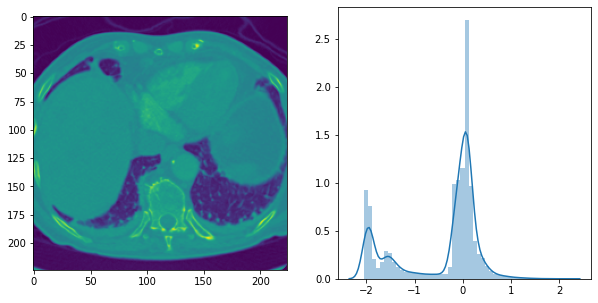

In [8]:
image, target, _ = pe_dataset[5]
image = image.squeeze(0)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(image)
sns.distplot(image.flatten(), ax=ax[1]);

In [9]:
get_weighted_sampler(pe_dataset, stage='train')
get_weighted_sampler(pe_dataset, stage='valid')

In [10]:
train_loader, valid_loader = get_loaders(33)

Train split:  3
Valid split:  7


In [11]:
data_iter = iter(train_loader)
#data_iter = iter(valid_loader)
data, target, indices = next(data_iter)
print(target)
print(indices)
print(data.shape)

tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([ 301737, 1205514,  324261,  343652,  398734,  380709,   24143,  327755,
        1096206,  734611, 1144685,  762311,  897554,   59373,  308740,  378175])
torch.Size([16, 1, 224, 224])


In [12]:
train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [13]:
indices = indices.tolist()
for index in indices:
    print(train_df.pe_present_on_image[index])

0
1
0
0
0
0
1
0
1
1
1
1
1
1
0
0


In [14]:
def get_original_image(pedataframe,idx):
    img_name = os.path.join(train_dir,
                            pedataframe.StudyInstanceUID[idx],
                            pedataframe.SeriesInstanceUID[idx],
                            pedataframe.SOPInstanceUID[idx] + '.dcm')
    dicom_image = pydicom.dcmread(img_name) 

    try:
        # RuntimeError: The following handlers are available to decode the pixel ...
        # data however they are missing required dependencies: GDCM (req. GDCM)
        image = dicom_image.pixel_array
    except:
        print('Error parsing ', img_name)
        return None

    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    image[image <= -1000] = 0

     # convert to HU using DICOM information
    # HU is a number between -1000 and 1000 (generally)
    # good lung tissue is between -950 and -700 (approximately)
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)

    image = image.astype(np.int16)
    image += np.int16(intercept)
    return image

In [15]:
data.shape

torch.Size([16, 1, 224, 224])

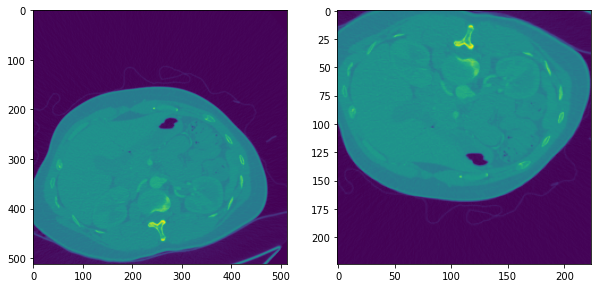

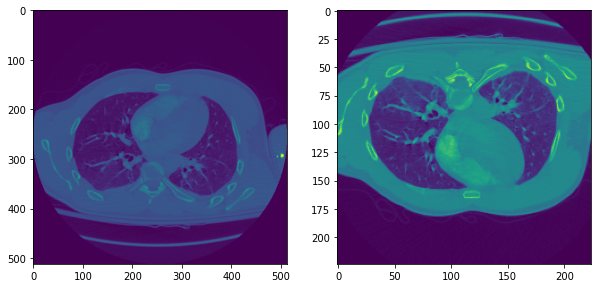

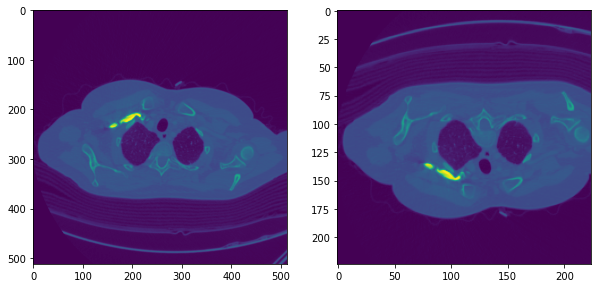

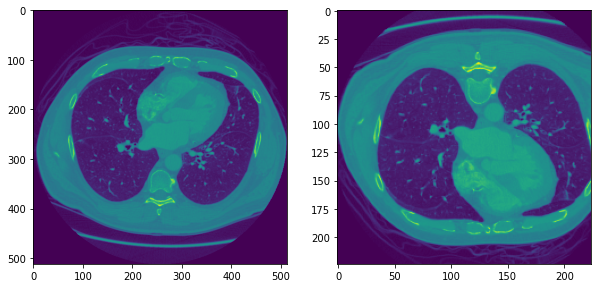

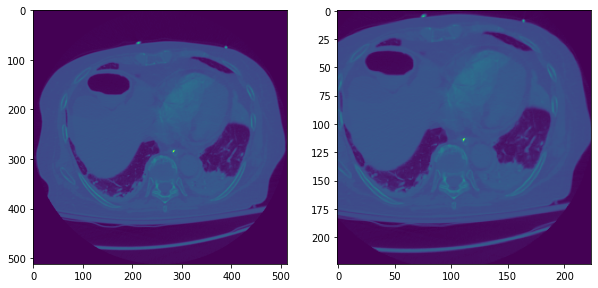

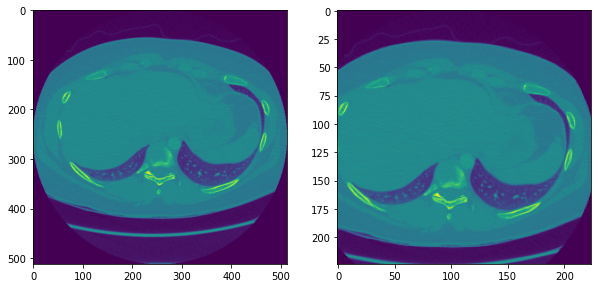

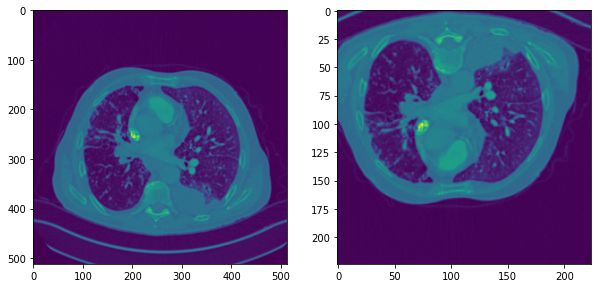

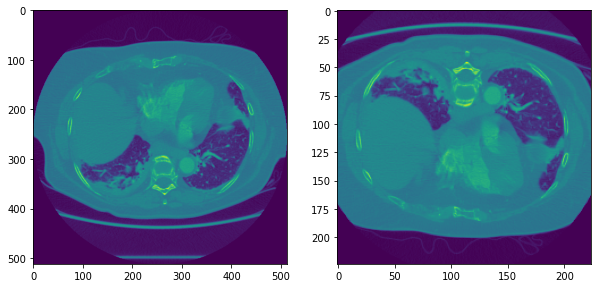

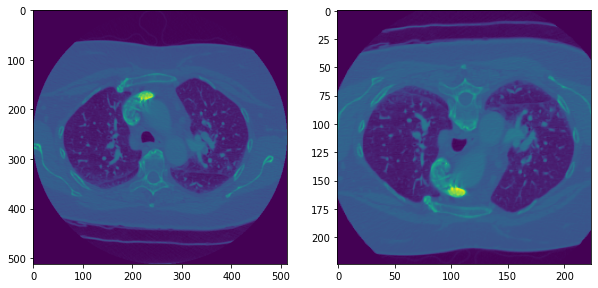

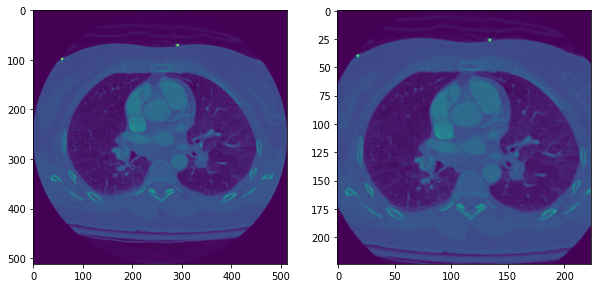

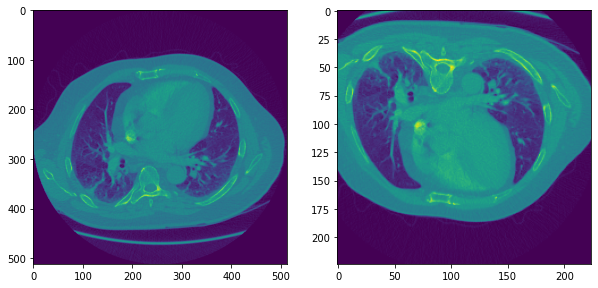

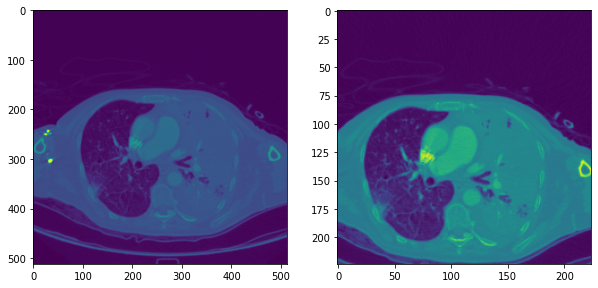

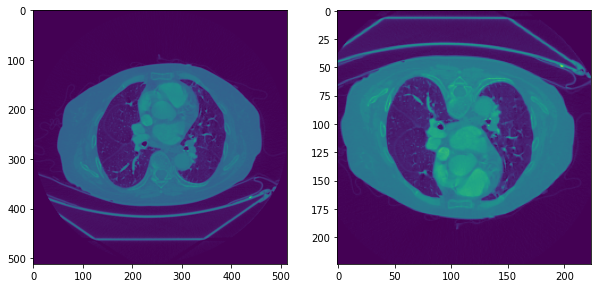

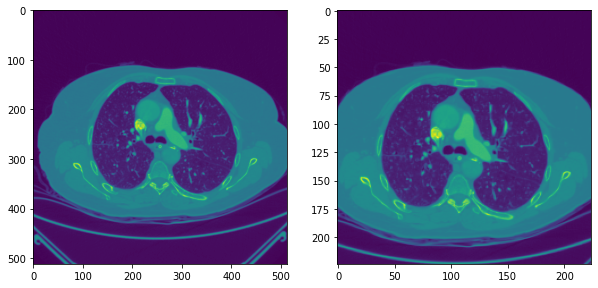

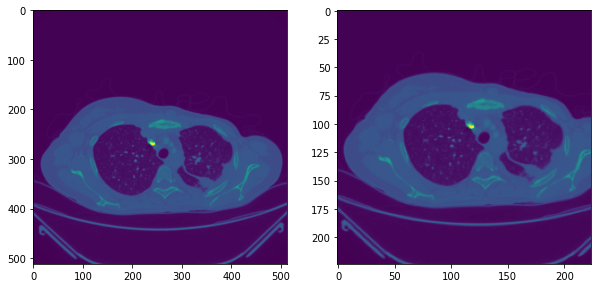

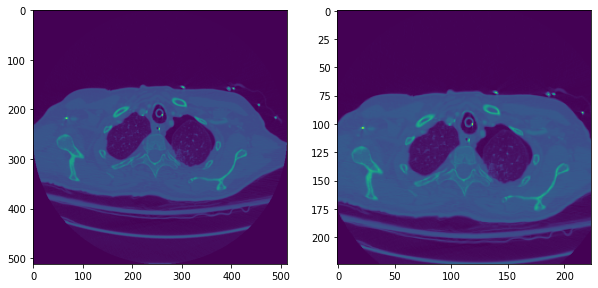

In [16]:
for i in range(len(indices)):
    index = indices[i]
    image = get_original_image(train_df, index)
    data_i = data[i,0,:,:]
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(image)
    ax[1].imshow(data_i)

***End Test Code***

In [17]:
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target):
    loss = bce(logits.view(-1), target.view(-1))
    return loss

In [18]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target, _) in bar:
        data, target = data.to(device), target.to(device)
        
        # zero gradients
        optimizer.zero_grad()

        #forward pass
        logits = model(data.float())
        
        # calculate loss
        loss = criterion(logits, target)

        # backpropagate the loss (backward pass)
        loss.backward()
 
        # update parameters based on accumulated gradients
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()

        train_loss.append(loss_np)
        average_loss = sum(train_loss) / len(train_loss)
        bar.set_description('loss: %.5f, mean: %.5f' % (loss_np, average_loss))
    return float(average_loss)

def valid_epoch(model, loader):
    model.eval()
    val_loss = []
    pos_logits = []
    neg_logits = []

    with torch.no_grad():
        for (data, target, _) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            loss_np = loss.detach().cpu().numpy()

            val_loss.append(loss_np)
            
            for i in range(logits.shape[-1]):
                b = target[i].detach().cpu().numpy()
                if b == 1:
                    pos_logits.append(logits[i].detach().cpu().numpy())
                else:
                    neg_logits.append(logits[i].detach().cpu().numpy())
                    
    val_loss = sum(val_loss) / len(val_loss)
    
    neg_logits_tensor = torch.FloatTensor(neg_logits).cuda()
    pos_logits_tensor = torch.FloatTensor(pos_logits).cuda()
    
    neg_loss = criterion(neg_logits_tensor, torch.zeros(neg_logits_tensor.shape).float().cuda())
    pos_loss = criterion(pos_logits_tensor, torch.ones(pos_logits_tensor.shape).float().cuda())
    
    neg_loss = neg_loss.detach().cpu().numpy()
    pos_loss = pos_loss.detach().cpu().numpy()
    
    neg_mean = float(torch.sigmoid(neg_logits_tensor).mean().detach().cpu().numpy())
    pos_mean = float(torch.sigmoid(pos_logits_tensor).mean().detach().cpu().numpy())
    
    return float(val_loss), float(pos_loss), float(neg_loss), pos_mean, neg_mean

In [19]:
!pip install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.7.7/install/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
from efficientnet_pytorch import EfficientNet
#since img_size chosen as 224, choose efficientnet-b0
cnn = EfficientNet.from_pretrained('efficientnet-b0',num_classes=1).cuda()
cnn._conv_stem.in_channels = 1
#model._conv_stem.weight = torch.nn.Parameter(torch.cat([model._conv_stem.weight, model._conv_stem.weight], axis=1))

Loaded pretrained weights for efficientnet-b0


In [21]:
cnn._conv_stem = torch.nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [22]:
cnn

EfficientNet(
  (_conv_stem): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
        (static_padding): Identity()
   

In [23]:
def get_optimizer(lr, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
    return optimizer

In [24]:
init_lr = 0.1
n_epochs = 40
#n_epochs = 1
device = 'cuda'

# reduce LR by gamma three times every 10 epochs
# each epoch is 100,000 samples
gamma = 10
schedule = [10, 20, 30]

#model = resnext101.to(device)
model = cnn.to(device)
optimizer = get_optimizer(init_lr, model)

master_train_loss = []
master_valid_loss = []
epoch = 1
#best_valid_loss = 10

global_mean = 0.0
global_std = 500.0
transform = T.Normalize(mean=[global_mean], std=[global_std])

In [25]:
print(optimizer.param_groups[0]["lr"])
print(optimizer)

0.1
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


In [26]:
while epoch <= n_epochs:
    print(time.ctime(), 'Epoch:', epoch)
    
    # update learning rate 
    if epoch in schedule:
        new_lr = optimizer.param_groups[0]["lr"] / gamma
        optimizer = get_optimizer(new_lr, model)
    
    train_loader, valid_loader = get_loaders(epoch)

    # train
    train_loss = train_epoch(model, train_loader, optimizer)
    optimizer.zero_grad()
    
    # validate
    valid_loss, pos_loss, neg_loss, pos_mean, neg_mean = valid_epoch(model, valid_loader)
    
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(valid_loss):.5f}'
    print(content)
    content = f'pos loss: {(pos_loss):.5f}, neg loss: {(neg_loss):.5f}, pos mean: {(pos_mean):.5f}, neg mean {(neg_mean):.5f}'
    print(content)
    master_train_loss.append(train_loss)
    master_valid_loss.append(valid_loss)
    
    # save loss data and model weights
    with open('train_loss.pkl', 'wb') as f:
        pickle.dump(master_train_loss, f)
    with open('valid_loss.pkl', 'wb') as f:
        pickle.dump(master_valid_loss, f)
        
        torch.save(model.state_dict(), 'model-efficientb0-{}.pth'.format(epoch))
        best_valid_loss = valid_loss
    
    epoch += 1
    
    # clean up scratch
    # dataset_train.destroy()
    # dataset_valid.destroy()
        

Wed Dec  2 08:21:07 2020 Epoch: 1
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:42<00:00, 32.37it/s]


Wed Dec  2 08:37:41 2020 Epoch 1, lr: 0.1000000, train loss: 0.47191, valid loss: 0.62637
pos loss: 0.51086, neg loss: 0.73616, pos mean: 0.60327, neg mean 0.51067
Wed Dec  2 08:37:41 2020 Epoch: 2
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:43<00:00, 32.18it/s]


Wed Dec  2 08:54:14 2020 Epoch 2, lr: 0.1000000, train loss: 0.45595, valid loss: 0.45318
pos loss: 0.56502, neg loss: 0.33788, pos mean: 0.59636, neg mean 0.24074
Wed Dec  2 08:54:14 2020 Epoch: 3
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:41<00:00, 32.65it/s]


Wed Dec  2 09:10:45 2020 Epoch 3, lr: 0.1000000, train loss: 0.45059, valid loss: 0.53140
pos loss: 0.44762, neg loss: 0.58850, pos mean: 0.67894, neg mean 0.36944
Wed Dec  2 09:10:45 2020 Epoch: 4
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:38<00:00, 33.56it/s]


Wed Dec  2 09:27:13 2020 Epoch 4, lr: 0.1000000, train loss: 0.45960, valid loss: 0.57106
pos loss: 0.64049, neg loss: 0.51001, pos mean: 0.56824, neg mean 0.35772
Wed Dec  2 09:27:13 2020 Epoch: 5
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:36<00:00, 34.49it/s]


Wed Dec  2 09:43:39 2020 Epoch 5, lr: 0.1000000, train loss: 0.46309, valid loss: 0.49370
pos loss: 0.38501, neg loss: 0.59279, pos mean: 0.72202, neg mean 0.32178
Wed Dec  2 09:43:39 2020 Epoch: 6
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:35<00:00, 34.91it/s]


Wed Dec  2 10:00:04 2020 Epoch 6, lr: 0.1000000, train loss: 0.44107, valid loss: 0.47709
pos loss: 0.26352, neg loss: 0.69295, pos mean: 0.78326, neg mean 0.39565
Wed Dec  2 10:00:04 2020 Epoch: 7
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:38<00:00, 33.71it/s]


Wed Dec  2 10:16:37 2020 Epoch 7, lr: 0.1000000, train loss: 0.45875, valid loss: 0.54746
pos loss: 0.80373, neg loss: 0.29133, pos mean: 0.49884, neg mean 0.20852
Wed Dec  2 10:16:37 2020 Epoch: 8
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:41<00:00, 32.55it/s]


Wed Dec  2 10:33:13 2020 Epoch 8, lr: 0.1000000, train loss: 0.45281, valid loss: 0.65360
pos loss: 0.09304, neg loss: 1.19118, pos mean: 0.92127, neg mean 0.49248
Wed Dec  2 10:33:13 2020 Epoch: 9
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:39<00:00, 33.19it/s]


Wed Dec  2 10:49:42 2020 Epoch 9, lr: 0.1000000, train loss: 0.44798, valid loss: 0.65722
pos loss: 0.56535, neg loss: 0.74196, pos mean: 0.74670, neg mean 0.27874
Wed Dec  2 10:49:42 2020 Epoch: 10
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:38<00:00, 33.68it/s]


Wed Dec  2 11:06:14 2020 Epoch 10, lr: 0.0100000, train loss: 0.41915, valid loss: 0.43889
pos loss: 0.55637, neg loss: 0.31789, pos mean: 0.65267, neg mean 0.21118
Wed Dec  2 11:06:14 2020 Epoch: 11
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:41<00:00, 32.77it/s]


Wed Dec  2 11:22:49 2020 Epoch 11, lr: 0.0100000, train loss: 0.41351, valid loss: 0.46216
pos loss: 0.60862, neg loss: 0.31155, pos mean: 0.60425, neg mean 0.22018
Wed Dec  2 11:22:50 2020 Epoch: 12
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:42<00:00, 32.42it/s]


Wed Dec  2 11:39:26 2020 Epoch 12, lr: 0.0100000, train loss: 0.38791, valid loss: 0.45900
pos loss: 0.69158, neg loss: 0.25014, pos mean: 0.59108, neg mean 0.17646
Wed Dec  2 11:39:26 2020 Epoch: 13
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:49<00:00, 30.33it/s]


Wed Dec  2 11:56:09 2020 Epoch 13, lr: 0.0100000, train loss: 0.40522, valid loss: 0.44021
pos loss: 0.44673, neg loss: 0.40950, pos mean: 0.69715, neg mean 0.26321
Wed Dec  2 11:56:09 2020 Epoch: 14
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:39<00:00, 33.18it/s]


Wed Dec  2 12:12:44 2020 Epoch 14, lr: 0.0100000, train loss: 0.39437, valid loss: 0.42642
pos loss: 0.48125, neg loss: 0.36071, pos mean: 0.68290, neg mean 0.23007
Wed Dec  2 12:12:45 2020 Epoch: 15
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:35<00:00, 34.90it/s]


Wed Dec  2 12:29:12 2020 Epoch 15, lr: 0.0100000, train loss: 0.39046, valid loss: 0.47845
pos loss: 0.35577, neg loss: 0.57011, pos mean: 0.76256, neg mean 0.31264
Wed Dec  2 12:29:12 2020 Epoch: 16
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:39<00:00, 33.47it/s]


Wed Dec  2 12:45:37 2020 Epoch 16, lr: 0.0100000, train loss: 0.39707, valid loss: 0.41794
pos loss: 0.35068, neg loss: 0.51054, pos mean: 0.75613, neg mean 0.28816
Wed Dec  2 12:45:37 2020 Epoch: 17
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:36<00:00, 34.49it/s]


Wed Dec  2 13:02:16 2020 Epoch 17, lr: 0.0100000, train loss: 0.39709, valid loss: 0.46741
pos loss: 0.50029, neg loss: 0.42742, pos mean: 0.68520, neg mean 0.25037
Wed Dec  2 13:02:16 2020 Epoch: 18
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:35<00:00, 34.87it/s]


Wed Dec  2 13:18:53 2020 Epoch 18, lr: 0.0100000, train loss: 0.37541, valid loss: 0.85597
pos loss: 0.07381, neg loss: 1.68935, pos mean: 0.94186, neg mean 0.52559
Wed Dec  2 13:18:53 2020 Epoch: 19
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:34<00:00, 35.10it/s]


Wed Dec  2 13:35:32 2020 Epoch 19, lr: 0.0100000, train loss: 0.39315, valid loss: 0.42200
pos loss: 0.52504, neg loss: 0.30853, pos mean: 0.64071, neg mean 0.21965
Wed Dec  2 13:35:32 2020 Epoch: 20
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:34<00:00, 35.21it/s]


Wed Dec  2 13:52:10 2020 Epoch 20, lr: 0.0010000, train loss: 0.37038, valid loss: 0.39158
pos loss: 0.36462, neg loss: 0.41934, pos mean: 0.76471, neg mean 0.24641
Wed Dec  2 13:52:10 2020 Epoch: 21
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:33<00:00, 35.49it/s]


Wed Dec  2 14:08:47 2020 Epoch 21, lr: 0.0010000, train loss: 0.35938, valid loss: 0.39890
pos loss: 0.40253, neg loss: 0.36788, pos mean: 0.73800, neg mean 0.22798
Wed Dec  2 14:08:47 2020 Epoch: 22
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 36.04it/s]


Wed Dec  2 14:25:08 2020 Epoch 22, lr: 0.0010000, train loss: 0.36299, valid loss: 0.38437
pos loss: 0.40627, neg loss: 0.35800, pos mean: 0.73349, neg mean 0.22916
Wed Dec  2 14:25:08 2020 Epoch: 23
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 35.79it/s]


Wed Dec  2 14:41:31 2020 Epoch 23, lr: 0.0010000, train loss: 0.36523, valid loss: 0.39958
pos loss: 0.48022, neg loss: 0.32120, pos mean: 0.69815, neg mean 0.20939
Wed Dec  2 14:41:31 2020 Epoch: 24
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 36.03it/s]


Wed Dec  2 14:57:52 2020 Epoch 24, lr: 0.0010000, train loss: 0.34286, valid loss: 0.39640
pos loss: 0.27781, neg loss: 0.53714, pos mean: 0.81471, neg mean 0.29142
Wed Dec  2 14:57:52 2020 Epoch: 25
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 35.99it/s]


Wed Dec  2 15:14:14 2020 Epoch 25, lr: 0.0010000, train loss: 0.35687, valid loss: 0.39338
pos loss: 0.42088, neg loss: 0.36177, pos mean: 0.73456, neg mean 0.22613
Wed Dec  2 15:14:14 2020 Epoch: 26
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 36.05it/s]


Wed Dec  2 15:30:33 2020 Epoch 26, lr: 0.0010000, train loss: 0.35114, valid loss: 0.37962
pos loss: 0.41586, neg loss: 0.35560, pos mean: 0.72679, neg mean 0.22800
Wed Dec  2 15:30:33 2020 Epoch: 27
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 35.88it/s]


Wed Dec  2 15:46:54 2020 Epoch 27, lr: 0.0010000, train loss: 0.34593, valid loss: 0.39308
pos loss: 0.33258, neg loss: 0.44882, pos mean: 0.78253, neg mean 0.26545
Wed Dec  2 15:46:54 2020 Epoch: 28
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 35.98it/s]


Wed Dec  2 16:03:14 2020 Epoch 28, lr: 0.0010000, train loss: 0.35289, valid loss: 0.39784
pos loss: 0.48345, neg loss: 0.29279, pos mean: 0.70185, neg mean 0.19091
Wed Dec  2 16:03:14 2020 Epoch: 29
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:31<00:00, 36.14it/s]


Wed Dec  2 16:19:35 2020 Epoch 29, lr: 0.0010000, train loss: 0.35571, valid loss: 0.40016
pos loss: 0.43089, neg loss: 0.35670, pos mean: 0.73045, neg mean 0.22711
Wed Dec  2 16:19:35 2020 Epoch: 30
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 36.00it/s]


Wed Dec  2 16:35:57 2020 Epoch 30, lr: 0.0001000, train loss: 0.34698, valid loss: 0.37442
pos loss: 0.37044, neg loss: 0.37779, pos mean: 0.75658, neg mean 0.23605
Wed Dec  2 16:35:57 2020 Epoch: 31
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 36.01it/s]


Wed Dec  2 16:52:20 2020 Epoch 31, lr: 0.0001000, train loss: 0.35280, valid loss: 0.38955
pos loss: 0.42799, neg loss: 0.37203, pos mean: 0.73307, neg mean 0.22933
Wed Dec  2 16:52:20 2020 Epoch: 32
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 35.90it/s]


Wed Dec  2 17:08:40 2020 Epoch 32, lr: 0.0001000, train loss: 0.34502, valid loss: 0.38238
pos loss: 0.39604, neg loss: 0.35649, pos mean: 0.74489, neg mean 0.21963
Wed Dec  2 17:08:41 2020 Epoch: 33
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 35.89it/s]


Wed Dec  2 17:25:04 2020 Epoch 33, lr: 0.0001000, train loss: 0.33861, valid loss: 0.39088
pos loss: 0.41105, neg loss: 0.33036, pos mean: 0.74339, neg mean 0.20828
Wed Dec  2 17:25:04 2020 Epoch: 34
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 36.01it/s]


Wed Dec  2 17:41:26 2020 Epoch 34, lr: 0.0001000, train loss: 0.34236, valid loss: 0.37169
pos loss: 0.39102, neg loss: 0.35049, pos mean: 0.75333, neg mean 0.22083
Wed Dec  2 17:41:26 2020 Epoch: 35
Train split:  5
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 35.92it/s]


Wed Dec  2 17:57:44 2020 Epoch 35, lr: 0.0001000, train loss: 0.34145, valid loss: 0.38863
pos loss: 0.42614, neg loss: 0.36126, pos mean: 0.73733, neg mean 0.22136
Wed Dec  2 17:57:44 2020 Epoch: 36
Train split:  0
Valid split:  6


100%|██████████| 3318/3318 [01:31<00:00, 36.11it/s]


Wed Dec  2 18:14:02 2020 Epoch 36, lr: 0.0001000, train loss: 0.33753, valid loss: 0.37367
pos loss: 0.35806, neg loss: 0.37051, pos mean: 0.76869, neg mean 0.23177
Wed Dec  2 18:14:02 2020 Epoch: 37
Train split:  1
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 36.03it/s]


Wed Dec  2 18:30:18 2020 Epoch 37, lr: 0.0001000, train loss: 0.34803, valid loss: 0.38421
pos loss: 0.38229, neg loss: 0.36756, pos mean: 0.75998, neg mean 0.22460
Wed Dec  2 18:30:18 2020 Epoch: 38
Train split:  2
Valid split:  6


100%|██████████| 3318/3318 [01:31<00:00, 36.18it/s]


Wed Dec  2 18:46:35 2020 Epoch 38, lr: 0.0001000, train loss: 0.33917, valid loss: 0.37690
pos loss: 0.39459, neg loss: 0.35061, pos mean: 0.75359, neg mean 0.21697
Wed Dec  2 18:46:35 2020 Epoch: 39
Train split:  3
Valid split:  7


100%|██████████| 3318/3318 [01:32<00:00, 36.02it/s]


Wed Dec  2 19:02:56 2020 Epoch 39, lr: 0.0001000, train loss: 0.33517, valid loss: 0.38121
pos loss: 0.37395, neg loss: 0.39207, pos mean: 0.76387, neg mean 0.23130
Wed Dec  2 19:02:56 2020 Epoch: 40
Train split:  4
Valid split:  6


100%|██████████| 3318/3318 [01:32<00:00, 35.98it/s]

Wed Dec  2 19:19:18 2020 Epoch 40, lr: 0.0001000, train loss: 0.34044, valid loss: 0.37181
pos loss: 0.39253, neg loss: 0.34467, pos mean: 0.74854, neg mean 0.21710


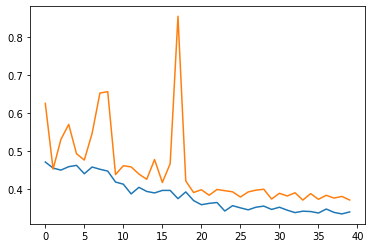

In [27]:
plt.plot(master_train_loss[:], label='train')
plt.plot(master_valid_loss[:], label='valid')